In [1]:
import os
from datetime import datetime

import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.rrt.rrt import RRTStar
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    draw_obstacles_pil, convert_to_obstacle_masks,
    randgen_obstacle_masks, draw_obstacles_pixel,
    vector_field, clip_vectors
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_samples

import matplotlib.pyplot as plt
import itertools
from typing import Optional
import shutil


# Args
config_dir = "./scorefield/configs/rrt.yaml"
args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))

img_size = args['image_size']
delta_dist = args['delta_dist']
radius = args['radius']
time_steps = args['time_steps']
sample_num = args['sample_num']

goal_bounds = args['goal_bounds']
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']

iterations = args['iterations']
train_lr = args['train_lr']
batch_size = args['batch_size']

/home/mlcs_edf/mambaforge/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_map = super().forward(obs, t)
        score = bilinear_interpolate_samples(score_map, x_t)    # output: (B,2)
        return score

    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

rrt = RRTStar(
    image_size=img_size,
    time_steps=time_steps,
    delta_dist=delta_dist,
    radius=radius,
    device=device,
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

In [13]:
# Train with random single goal

current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join('./runs/expert/', current_time)
writer = SummaryWriter(log_dir)
shutil.copy('./scorefield/configs/rrt.yaml', writer.log_dir)

assert batch_size % 2 == 0

# background = draw_obstacles_pil(bg, obstacle_pos)
# obstacle_masks = convert_to_obstacle_masks(batch_size, background[0].size, img_size, obstacle_pos)

for iters in tqdm(range(iterations)):
    obstacle_masks = randgen_obstacle_masks(batch_size, img_size) #.repeat_interleave(sample_num, dim=0)
    background = draw_obstacles_pixel(bg, obstacle_masks)
    goals = gen_goals(goal_bounds, batch_size, img_size, obstacles=obstacle_masks)
    goal = (torch.rand(batch_size, 1, 2, device=device, dtype=torch.float32) * 0.2 - 0.1) * 0.1 + goals
    obs = overlay_goal(background, img_size, wastes, goal)
    initials = gen_goals(goal_bounds, batch_size, img_size, obstacles=obstacle_masks)

    optim.zero_grad()
    
    losses = []
    deltas = []
    pred_deltas = []
    
    for i in range(time_steps):
        t = torch.ones(1).long().to(device)
        with torch.no_grad():
            paths, delta = rrt.plan(initials, goal, obstacle_masks)
        pred_delta = model(obs, t, paths[:,i].unsqueeze(1))
        
        squared_diff = torch.sum((pred_delta - delta[:, i].unsqueeze(1))**2, dim=-1)
        losses.append(torch.mean(squared_diff))
        deltas.append(delta[:, i])
        pred_deltas.append(pred_delta.unsqueeze(1))
        
    loss = sum(losses)/len(losses)
    loss.backward()
    optim.step()
    deltas = torch.stack(deltas)
    pred_deltas = torch.stack(pred_deltas)
    
    deltas_norm = torch.norm(deltas.detach(), dim=-1)
    pred_deltas_norm = torch.norm(pred_deltas.detach(), dim=-1)
    
    dotprod = torch.sum(deltas.detach() * pred_deltas.detach(), dim=-1)
    cosine_sim = dotprod / (torch.norm(deltas.detach(), dim=-1) * torch.norm(pred_deltas.detach(), dim=-1)+1e-8)
    
    writer.add_scalar("Loss/train", loss.item(), iters)
    writer.add_scalar("Norm/target_score", torch.mean(deltas_norm).item(), iters)
    writer.add_scalar("Norm/pred_score", torch.mean(pred_deltas_norm).item(), iters)
    writer.add_scalar("Similarity/dot_product", torch.mean(dotprod).item(), iters)
    writer.add_scalar("Similarity/cosine_similarity", torch.mean(cosine_sim).item(), iters)

    if iters == iterations // 2:
        torch.save(model.state_dict(), os.path.join(writer.log_dir, 'model_params_half.pt'))

torch.save(model.state_dict(), os.path.join(writer.log_dir, 'model_params.pt'))
            
writer.close()


  0%|          | 0/6000 [00:00<?, ?it/s]

torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])
torch.Size([18, 10, 2]) torch.Size([18, 10, 2])


  0%|          | 0/6000 [00:03<?, ?it/s]


RuntimeError: The size of tensor a (10) must match the size of tensor b (18) at non-singleton dimension 1

In [11]:
print(torch.norm(deltas, dim=-1).shape)

torch.Size([10, 18])


In [16]:
print(deltas.shape,pred_deltas.shape)

torch.Size([10, 18, 2]) torch.Size([10, 18, 1, 2])


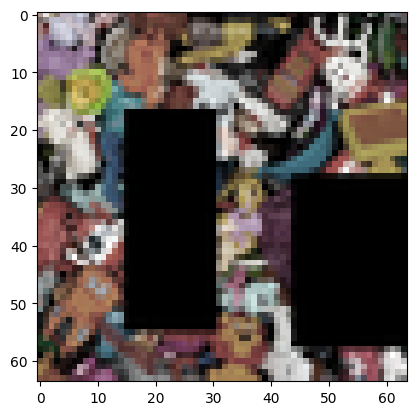

In [12]:
plt.imshow(obs[6].permute(1,2,0).cpu().numpy())
plt.show()